#INFO

**Moutning google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##imports

In [ ]:
import pandas as pd
import numpy as np


DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

#utils

##**Metrics**

Mean IOU

In [ ]:
def iou_coef1(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
def iou_coef2(y_true, y_pred):
  smooth = K.epsilon() ##
  thr = 0.5 ###
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # apply threshold to prediction
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

Pixel accuracy

In [ ]:
def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels

Pescision and Recall

In [ ]:
def recall(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + smooth)
  return recall

def precision(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + smooth)
  return precision

F1 score

In [ ]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    # Ensure the F1 score is defined even when precision and recall are 0
    if p + r == 0:
        return 0.0

    f1 = 2 * ((p * r) / (p + r))
    return f1

In [ ]:
metrics = [iou_coef1,
           iou_coef2,
           #pixel_accuracy,
           recall,
           precision,
           f1]

##**Loss**

especially with class imbalance (which is common in biomedical imaging where the region of interest is often small compared to the entire image), the Dice loss alone may not be the best choice, as it can be biased towards the majority class. 
source : chatgpt

**Dice Loss**

In [ ]:
def dice_coef(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


**IOU loss**

In [ ]:
def iou_loss1(y_true, y_pred):
    return 1 - iou_coef1(y_true, y_pred)

In [ ]:
def iou_loss2(y_true, y_pred):
    return 1 - iou_coef2(y_true, y_pred)

**focal loss**

In [ ]:
def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss

**combind losses**

In [ ]:
#dice loss combind with binary_crossentropy
def loss1(y_true, y_pred):
    binary_crossentropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return binary_crossentropy + dice_loss

In [ ]:
#dice coeff and iou coeff loss combind
def loss2(y_true, y_pred):
  return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef1(y_true, y_pred))

##**Optimizers**

In [ ]:
def optimizer(lr):
  
  optimizer = optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
  )
  return optimizer

def lr_schedule(initial = 0.01):
  initial_learning_rate = 0.01
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                               decay_steps=100000, 
                                                               decay_rate=0.96, staircase=True
                                                                )
  return lr_schedule

##**callbacks**

In [ ]:
def build_callbacks(model_name):
    callback= [ModelCheckpoint(f'/content/drive/MyDrive/models/{model_name}.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = 10, verbose =1, restore_best_weights=True ,monitor = "val_loss")]
    return callback

#Model architicture

In [ ]:
def unet(input_size = (256,256,1) , sart_neurons = 32):
    inputs = Input(input_size)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(sart_neurons * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


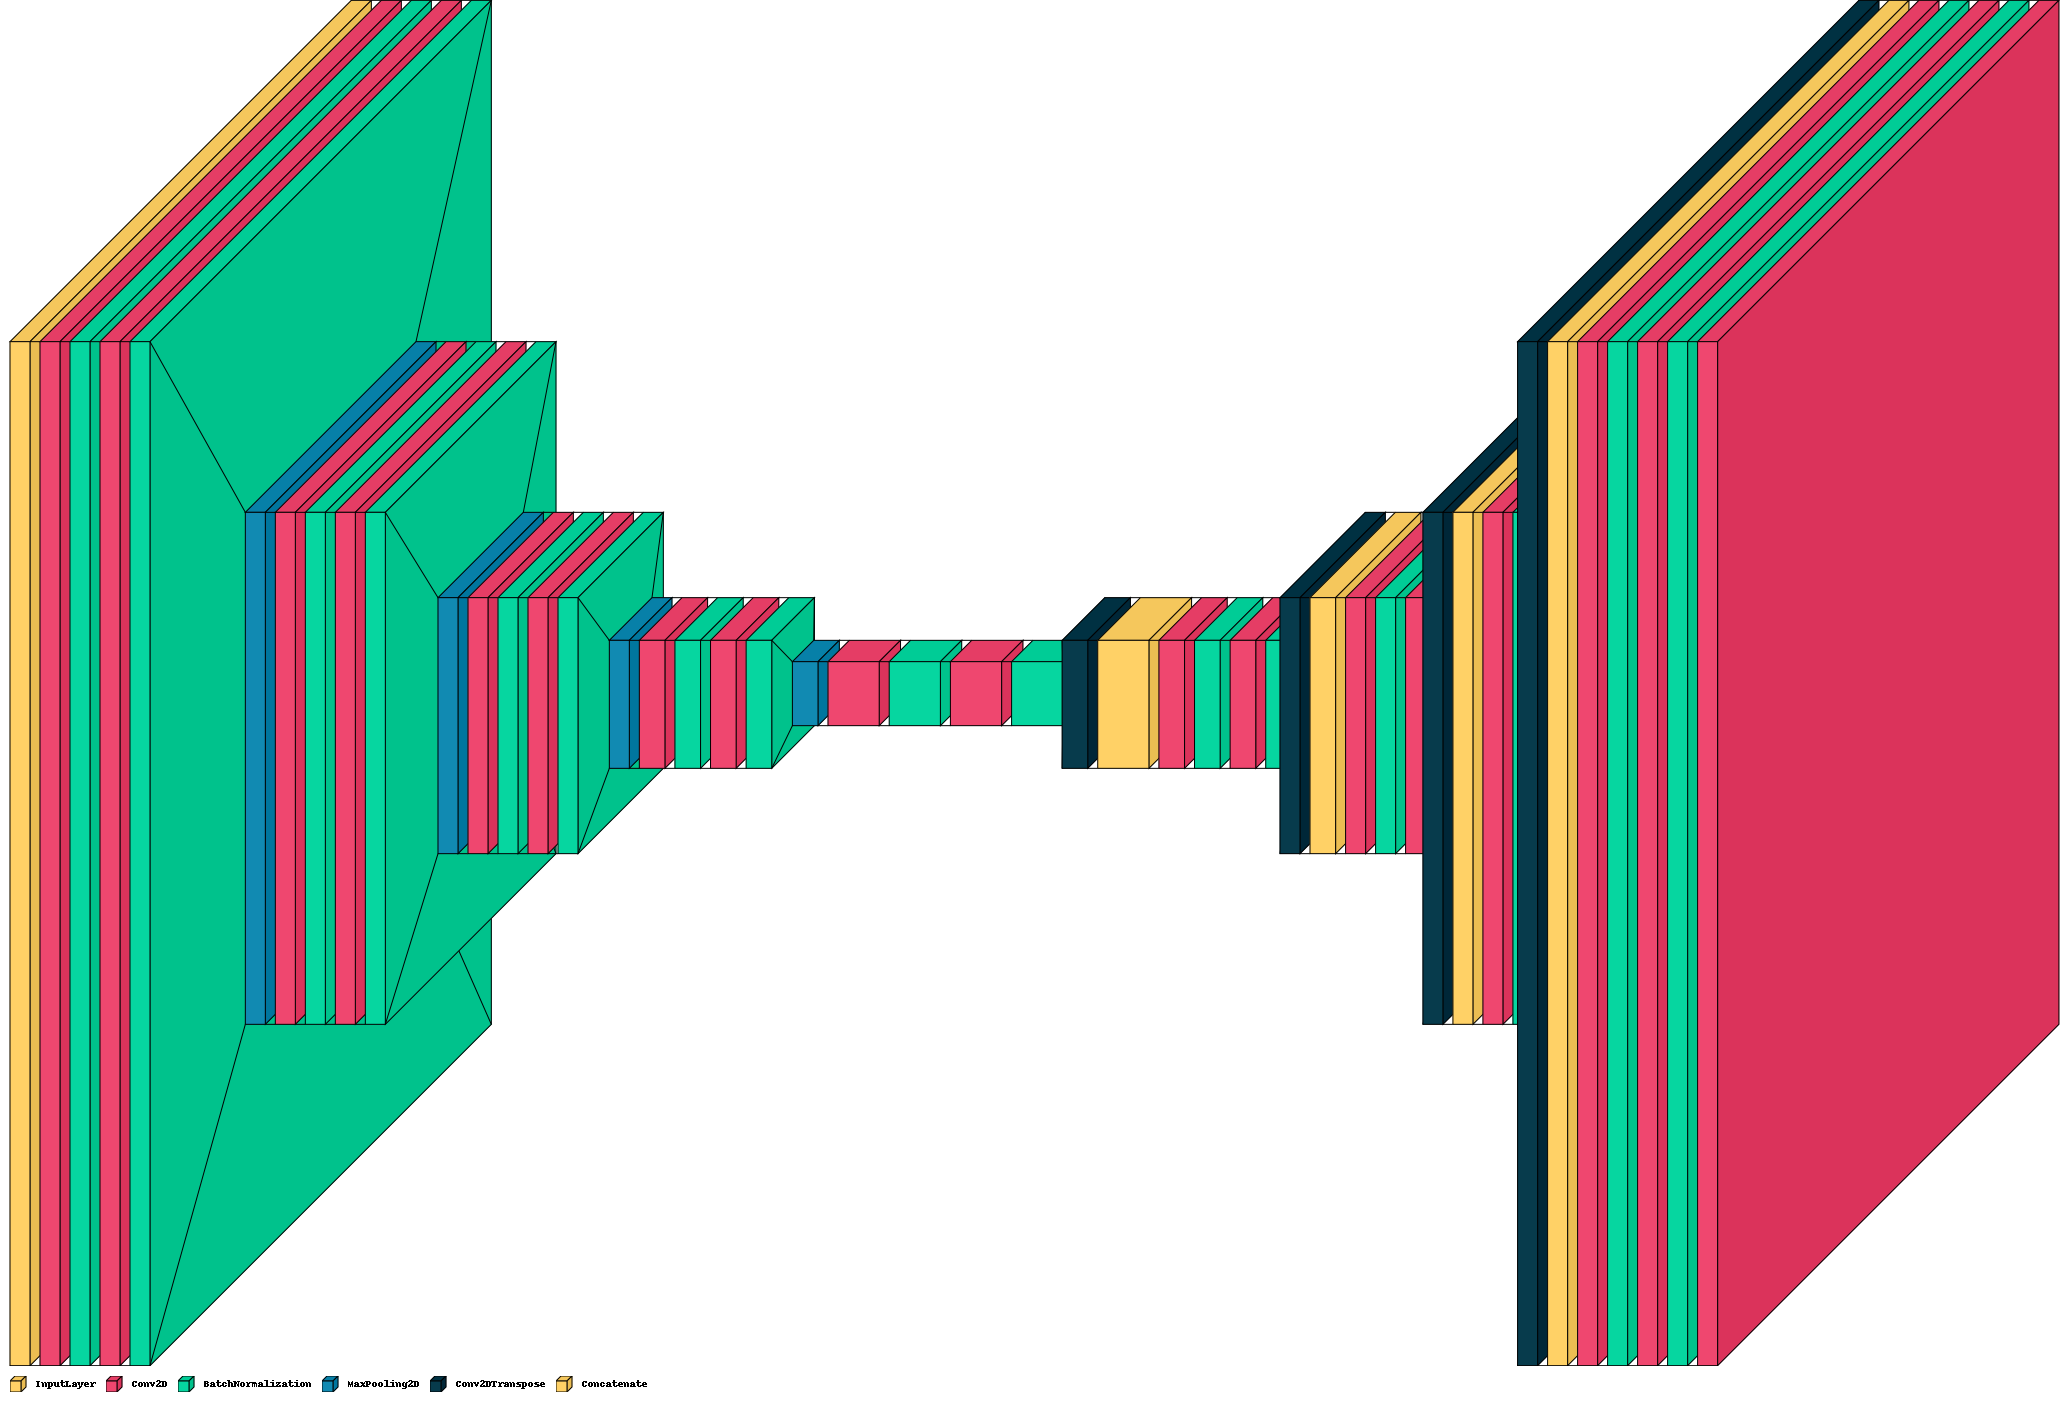

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

#**Fitting**

for the trining we will we can change different

 - optimizers
 - losses
 - we can also change the number of nnuerons in our model

##functions

defining a function to train the model of which some parameters we can change

In [ ]:
x_train = None 
x_test = None
y_train = None
y_test = None
x_val = None
y_val = None

In [ ]:
def train(name,opt, loss, d_divisor = 1, batch_size = 1 , epochs = 100 , sart_neurons = 32 , verbose = 0):
  # optimizor
  # loss
  # data divisor is used to make the data smaller d_divisor = 1 mean it's the largest data
  global x_train, x_test, y_train, y_test, x_val, y_val

  #spliting the data
  IMAGES_sub = np.split(IMAGES, d_divisor)[0] 
  MASKS_sub = np.split(MASKS, d_divisor)[0] 

  # Split dataset into train and test sets (80/20 split)
  x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

  # Split training set into train and validation sets (80/20 split)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

  # the model needs the mask to be floating point
  y_train = y_train.astype('float32')
  y_val = y_val.astype('float32')

  #model compilation
  model = unet(sart_neurons = sart_neurons)
  model.compile(opt, loss=loss, metrics=metrics)

  train_steps = x_train.shape[0] // batch_size
  test_steps = x_val.shape[0] // batch_size


  print("\n Model is training") 

  history = model.fit(x=x_train, 
                      y=y_train, 
                      epochs=epochs,
                      steps_per_epoch = train_steps, 
                      validation_steps= test_steps ,
                      callbacks = build_callbacks(name),
                      batch_size = batch_size, 
                      validation_data=(x_val, y_val),
                      shuffle=False,
                      verbose = verbose)
  
  print("\n Model history")
  
  plot_history(history)

  print("\n ====================================================")
  print("\n predicting on a test set") 

  pred = model.predict(x_test)

  print("\n plotting a sample of the predicted output")
  plot_prediction(pred)

  return model , history

**Function to plot the history**

In [ ]:
def plot_history(history):
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    num_cols = 3
    num_rows = math.ceil(num_metrics / num_cols)

    plt.figure(figsize=(12, 4 * num_rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_rows, num_cols, i+1)
        
        plt.plot(history.history[metric])
        if 'val_'+metric in history.history.keys():
            plt.plot(history.history['val_'+metric])
        
        plt.title('Model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

function to plot a random sample

In [ ]:
def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

def plot_prediction(y_pred, num_samples=5):
    # Choose random indices
    indices = np.random.choice(np.arange(y_pred.shape[0]), size=num_samples, replace=False)
    
    for idx in indices:
        # Get data
        x = x_test[idx]
        true = y_test[idx] # true mask
        pred = y_pred[idx]
        binary_pred = np.where(pred > 0.5, 1, 0) #pred after post proccessing


        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot original image
        axs[0].imshow(x)
        axs[0].set_title("Original Image")

        # Plot prediction
        axs[1].imshow(pred.squeeze(), cmap='gray')
        axs[1].set_title("Predicted")

        # Plot binary prediction
        axs[2].imshow(binary_pred.squeeze(), cmap='gray')
        axs[2].set_title("Binary Predicted")


        # Plot ground truth
        axs[3].imshow(true.squeeze(), cmap='gray')
        axs[3].set_title("Ground Truth")


        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

##using dice loss

optimizer adam(lr = 0.001)



 Model is training

Epoch 1: val_loss improved from inf to 0.90296, saving model to /content/drive/MyDrive/models/dice_opt1.h5

Epoch 2: val_loss improved from 0.90296 to 0.82953, saving model to /content/drive/MyDrive/models/dice_opt1.h5

Epoch 3: val_loss did not improve from 0.82953

Epoch 4: val_loss did not improve from 0.82953

Epoch 5: val_loss did not improve from 0.82953

Epoch 6: val_loss did not improve from 0.82953

Epoch 7: val_loss did not improve from 0.82953

Epoch 8: val_loss did not improve from 0.82953

Epoch 9: val_loss improved from 0.82953 to 0.78957, saving model to /content/drive/MyDrive/models/dice_opt1.h5

Epoch 10: val_loss did not improve from 0.78957

Epoch 11: val_loss did not improve from 0.78957

Epoch 12: val_loss improved from 0.78957 to 0.78102, saving model to /content/drive/MyDrive/models/dice_opt1.h5

Epoch 13: val_loss did not improve from 0.78102

Epoch 14: val_loss did not improve from 0.78102

Epoch 15: val_loss did not improve from 0.78102

E

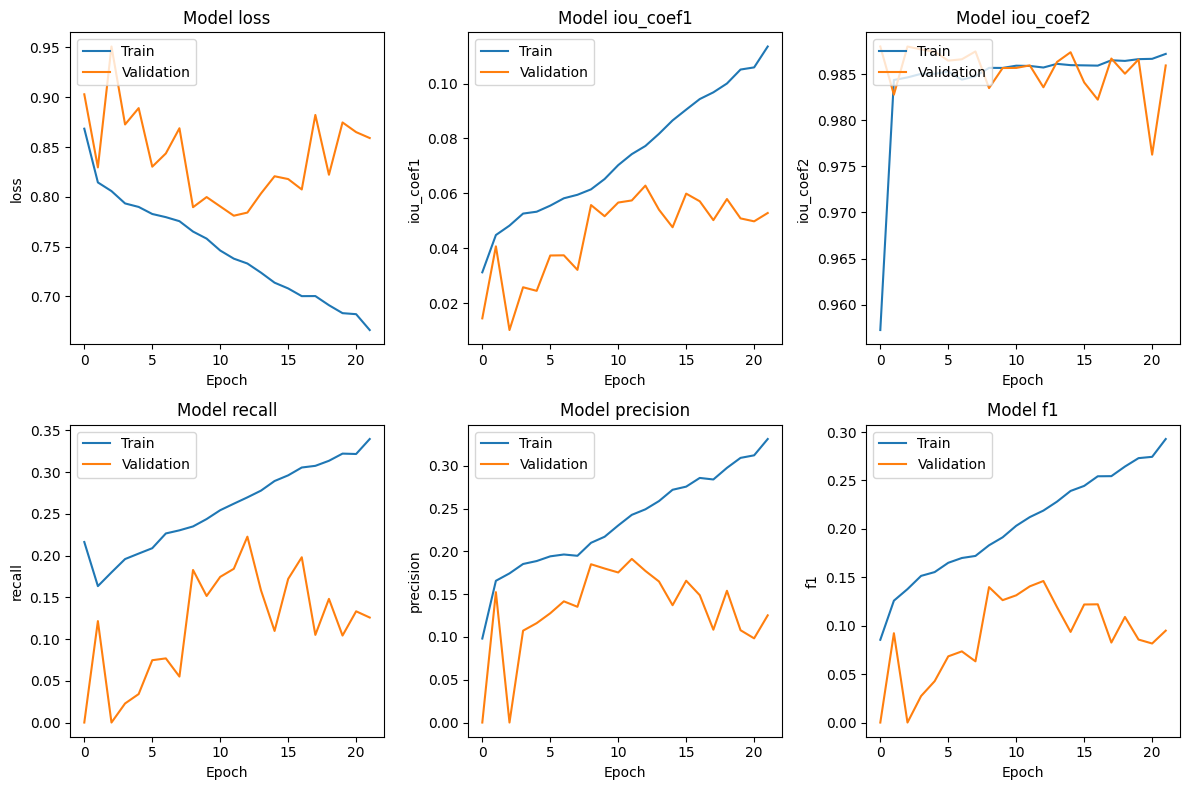



 predicting on a test set
23/23 [==============================] - 12s 267ms/step

 plotting a sample of the predicted output


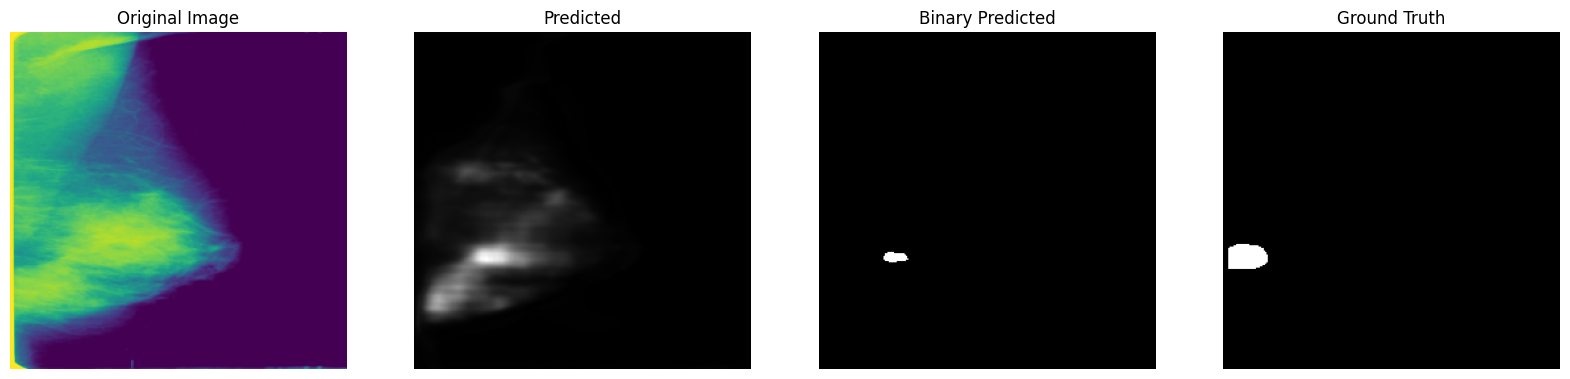

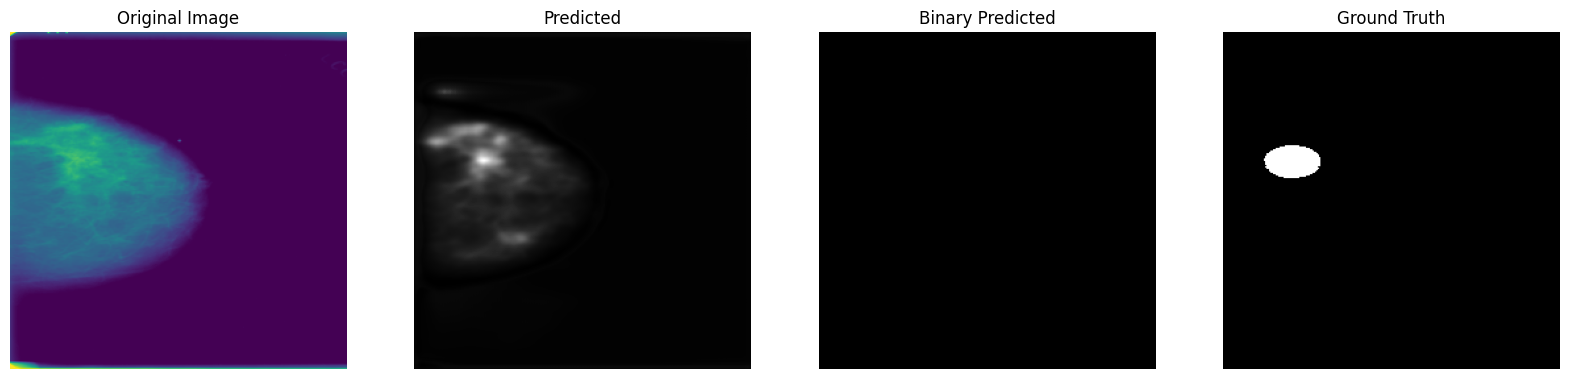

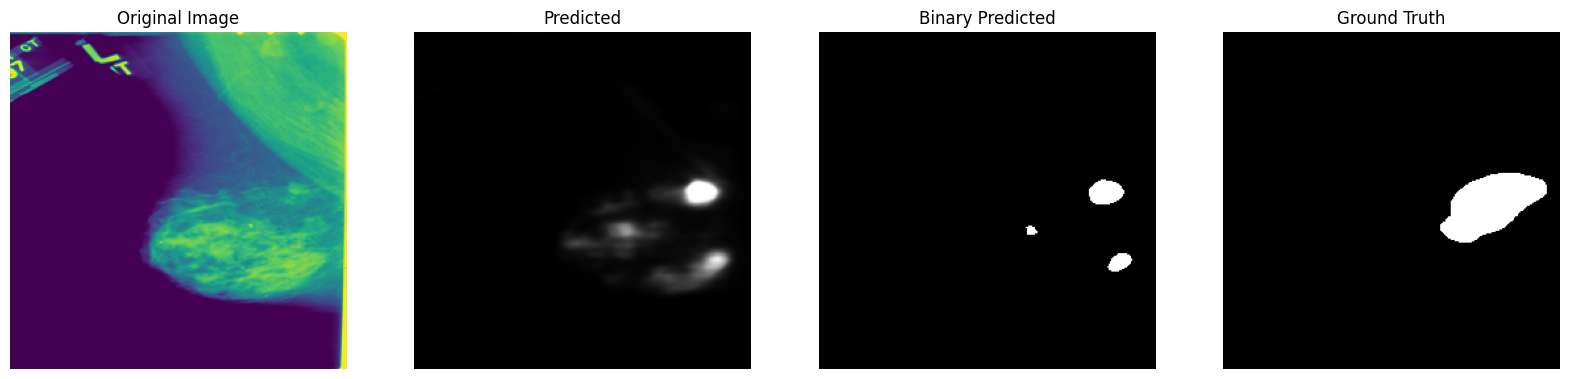

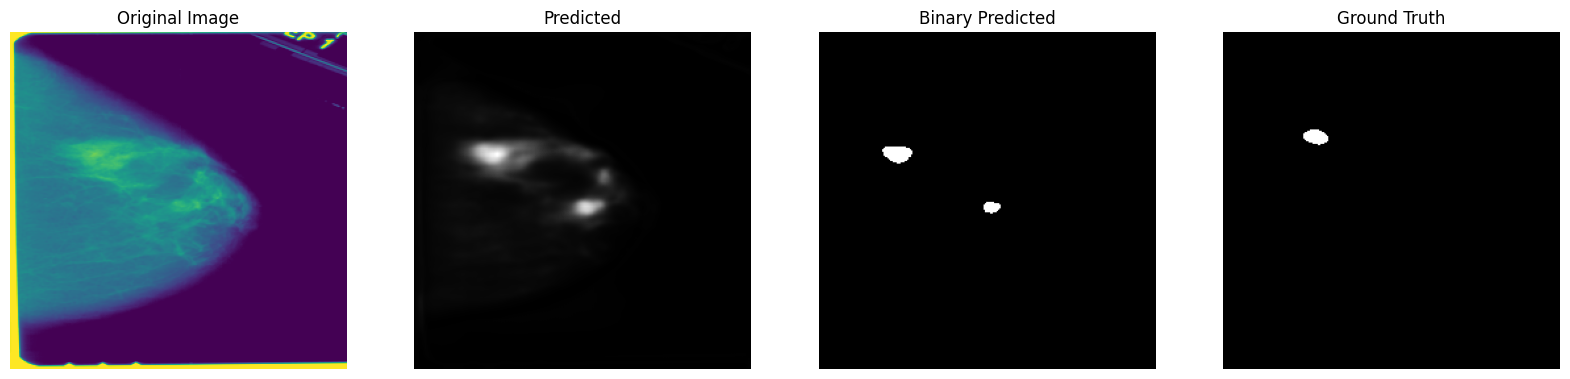

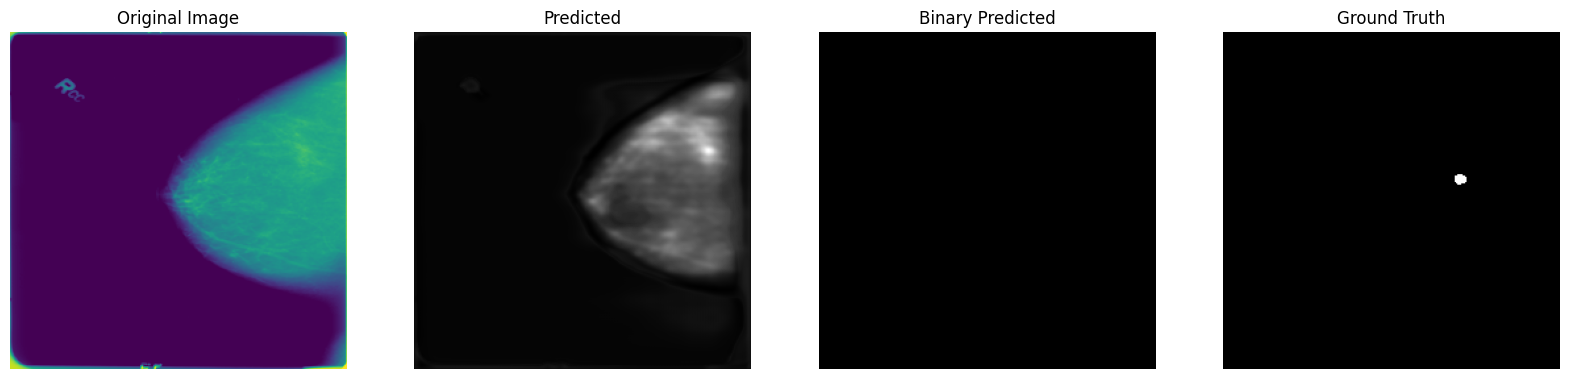

(<keras.engine.functional.Functional at 0x7fd9deceed10>,
 <keras.callbacks.History at 0x7fda000c9450>)

In [ ]:
train("dice_opt1",opt = optimizer(0.001), loss = dice_loss)

optimizer adam(lr = learning schedual)


 Model is training

Epoch 1: val_loss improved from inf to 0.86361, saving model to /content/drive/MyDrive/models/dice_opt2.h5

Epoch 2: val_loss did not improve from 0.86361

Epoch 3: val_loss did not improve from 0.86361

Epoch 4: val_loss improved from 0.86361 to 0.83246, saving model to /content/drive/MyDrive/models/dice_opt2.h5

Epoch 5: val_loss did not improve from 0.83246

Epoch 6: val_loss did not improve from 0.83246

Epoch 7: val_loss did not improve from 0.83246

Epoch 8: val_loss improved from 0.83246 to 0.80419, saving model to /content/drive/MyDrive/models/dice_opt2.h5

Epoch 9: val_loss did not improve from 0.80419

Epoch 10: val_loss did not improve from 0.80419

Epoch 11: val_loss did not improve from 0.80419

Epoch 12: val_loss did not improve from 0.80419

Epoch 13: val_loss did not improve from 0.80419

Epoch 14: val_loss improved from 0.80419 to 0.78260, saving model to /content/drive/MyDrive/models/dice_opt2.h5

Epoch 15: val_loss did not improve from 0.78260

E

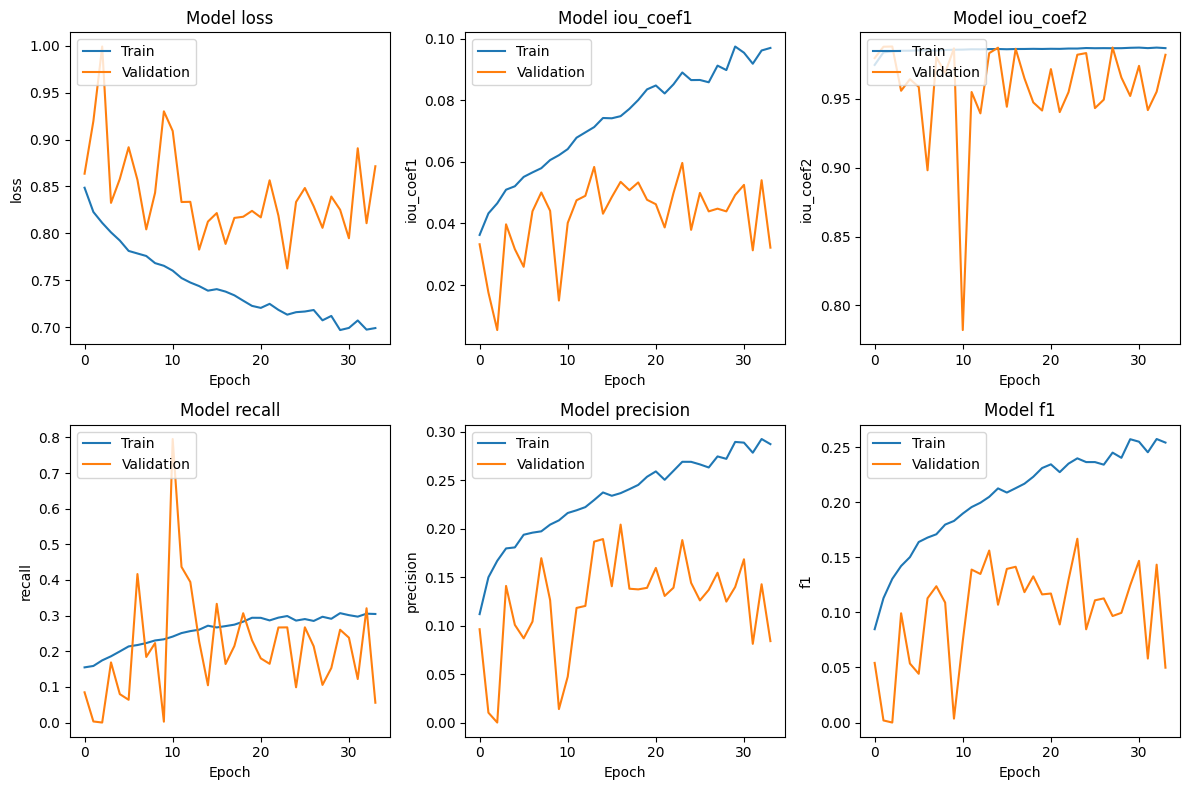



 predicting on a test set
23/23 [==============================] - 4s 163ms/step

 plotting a sample of the predicted output


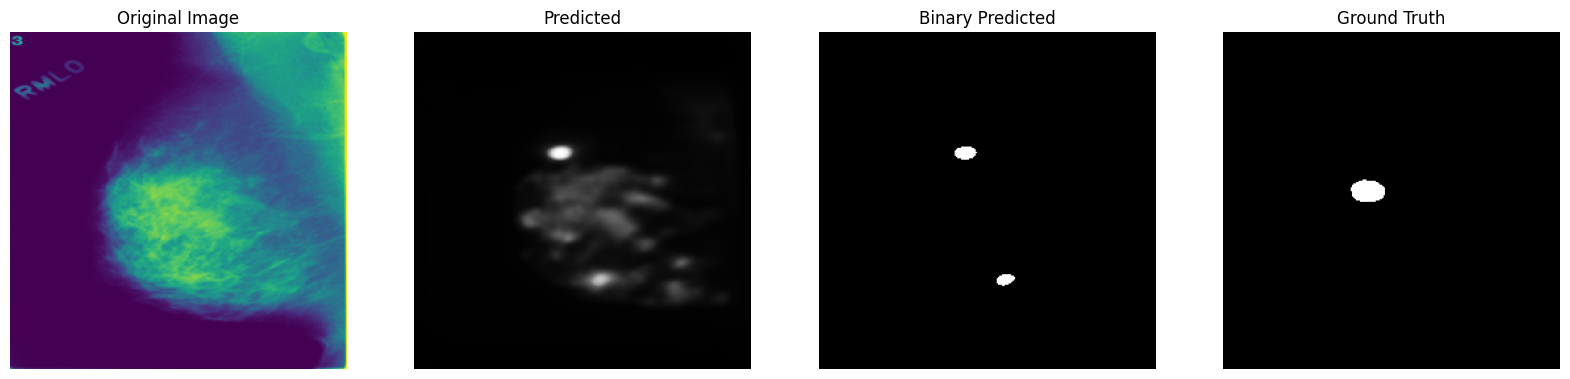

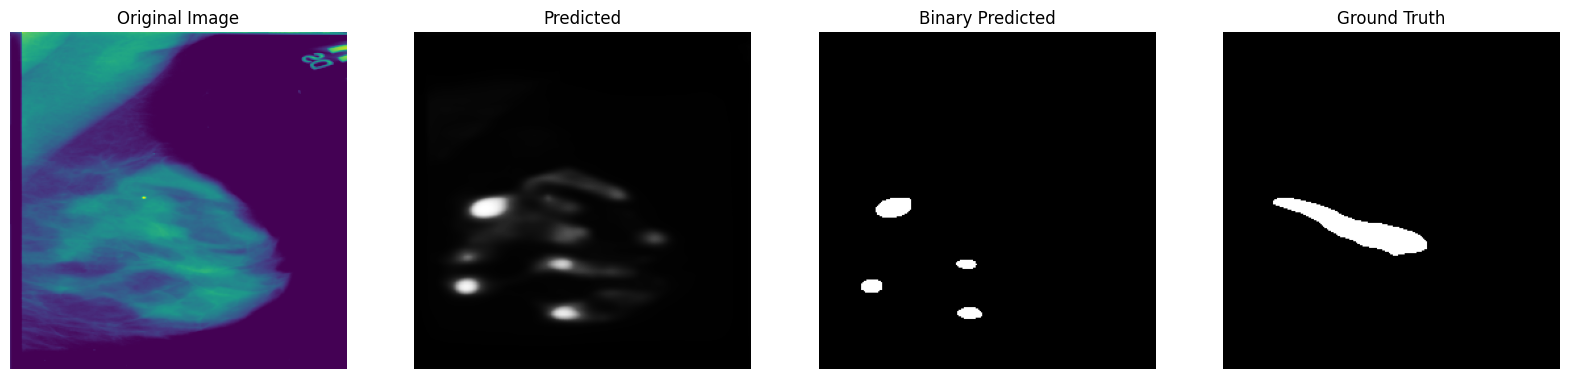

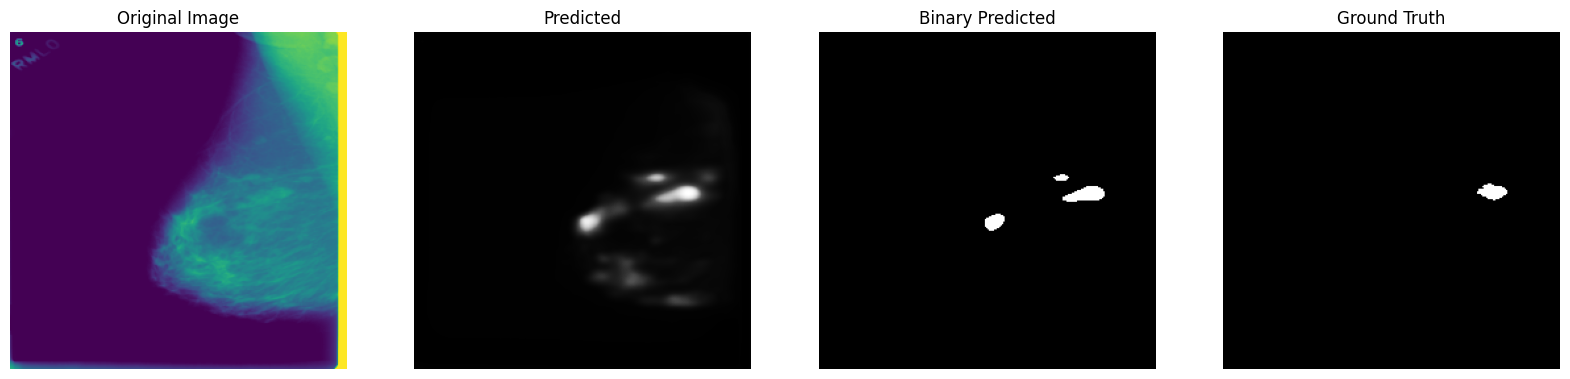

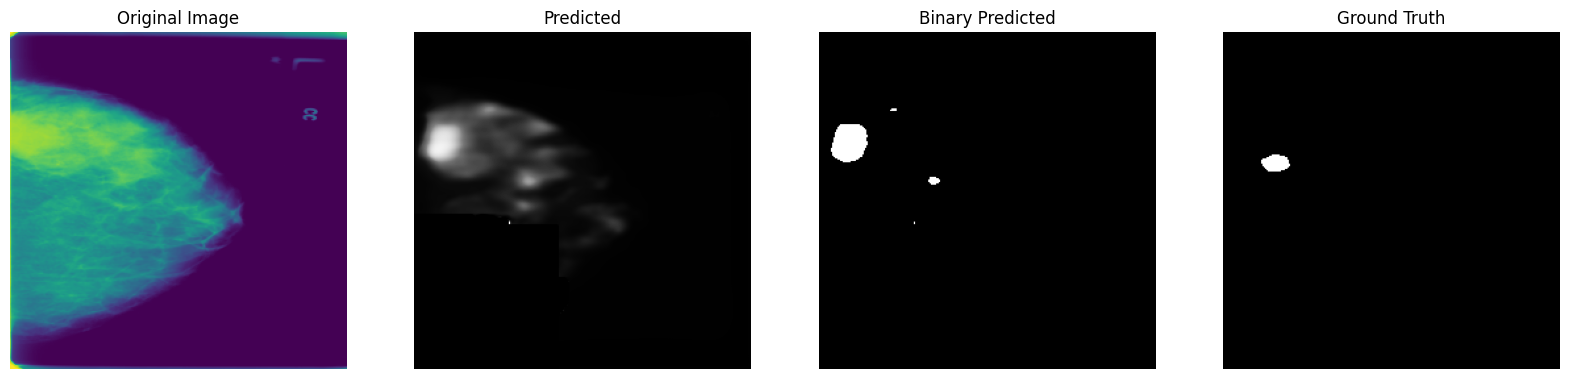

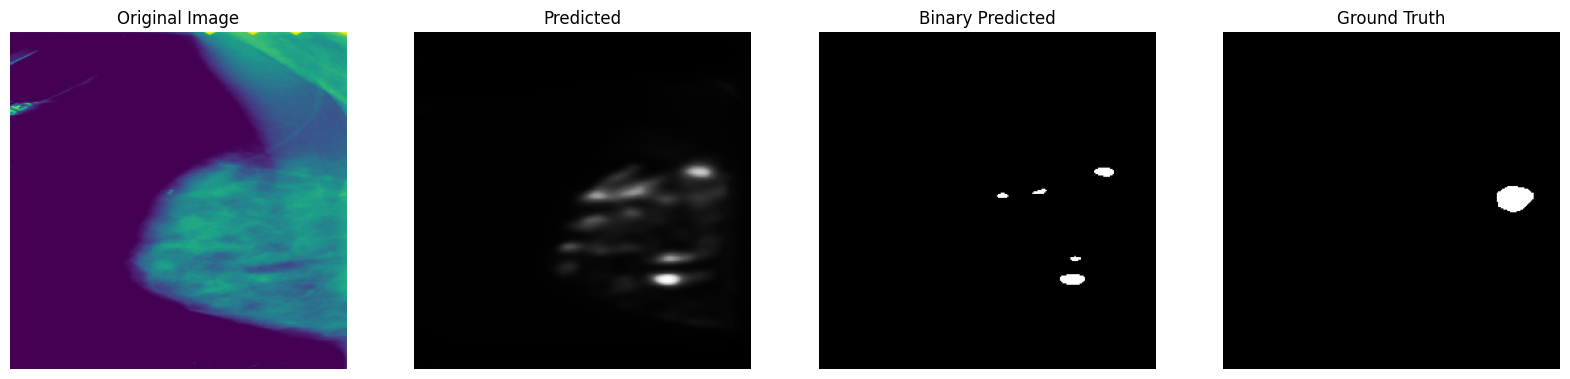

(<keras.engine.functional.Functional at 0x7fd911076bc0>,
 <keras.callbacks.History at 0x7fd926672800>)

In [ ]:
train("dice_opt2",opt = optimizer(lr_schedule()), loss = dice_loss)

##using iou_loss

optimizer 1


 Model is training

Epoch 1: val_loss improved from inf to 0.95997, saving model to /content/drive/MyDrive/models/iou_opt1.h5

Epoch 2: val_loss improved from 0.95997 to 0.95954, saving model to /content/drive/MyDrive/models/iou_opt1.h5

Epoch 3: val_loss did not improve from 0.95954

Epoch 4: val_loss did not improve from 0.95954

Epoch 5: val_loss did not improve from 0.95954

Epoch 6: val_loss did not improve from 0.95954

Epoch 7: val_loss did not improve from 0.95954

Epoch 8: val_loss did not improve from 0.95954

Epoch 9: val_loss did not improve from 0.95954

Epoch 10: val_loss did not improve from 0.95954

Epoch 11: val_loss did not improve from 0.95954

Epoch 12: val_loss did not improve from 0.95954
Restoring model weights from the end of the best epoch: 2.
Epoch 12: early stopping

 Model history


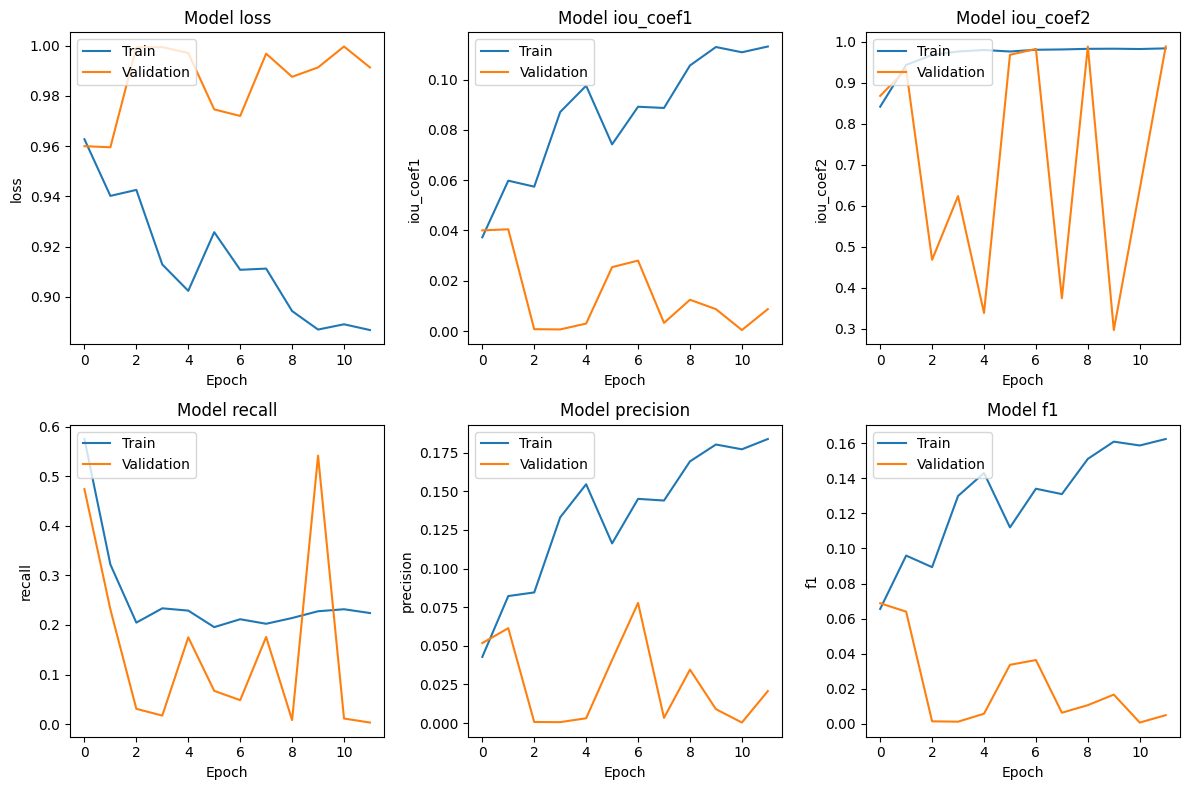



 predicting on a test set
23/23 [==============================] - 4s 166ms/step

 plotting a sample of the predicted output


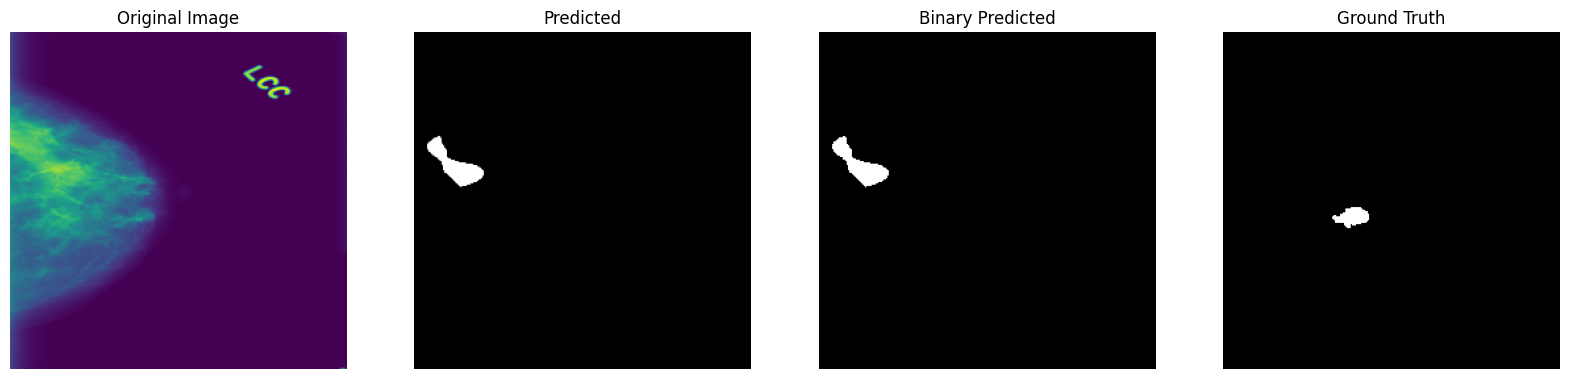

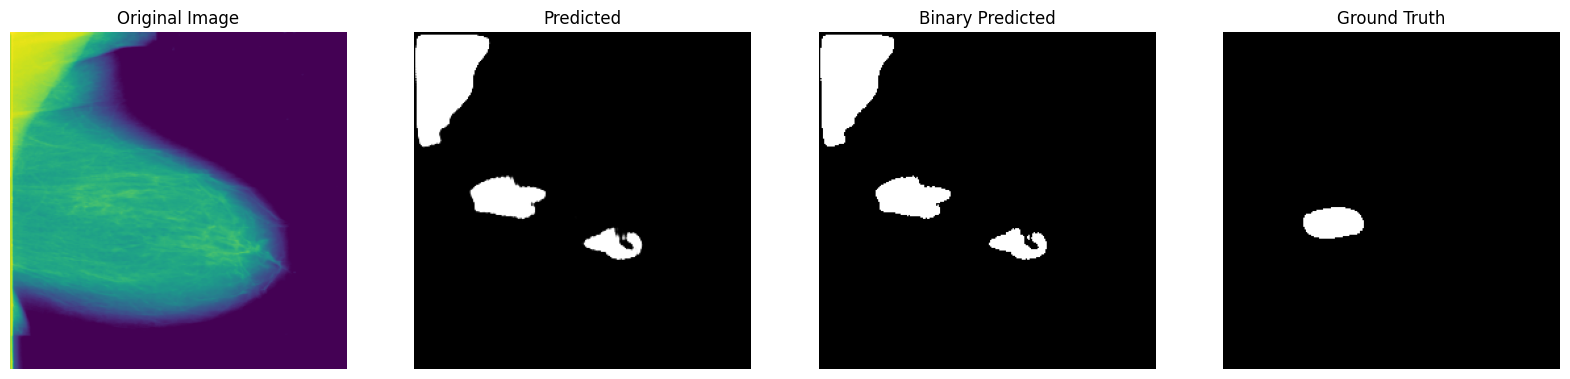

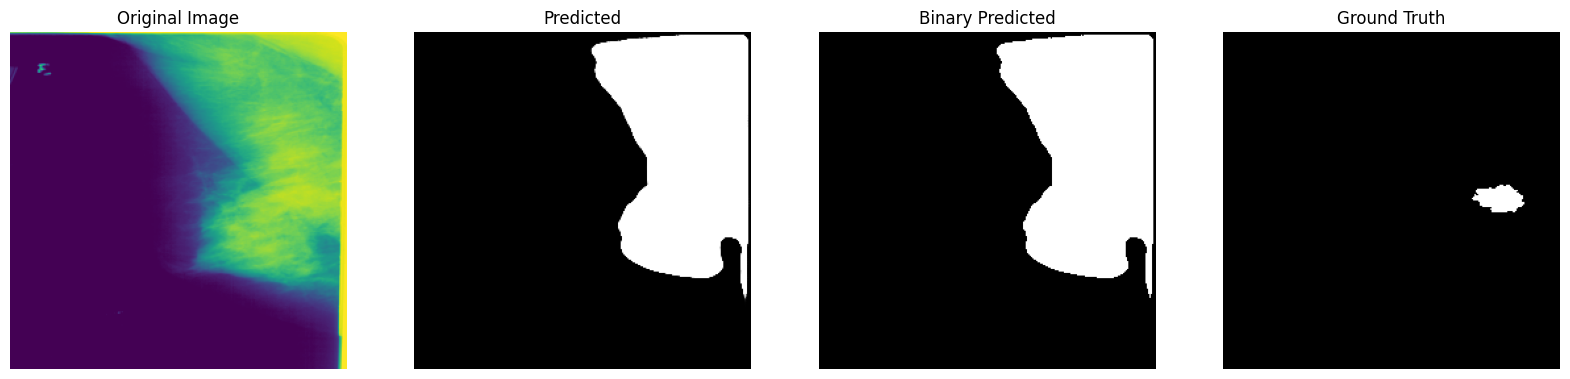

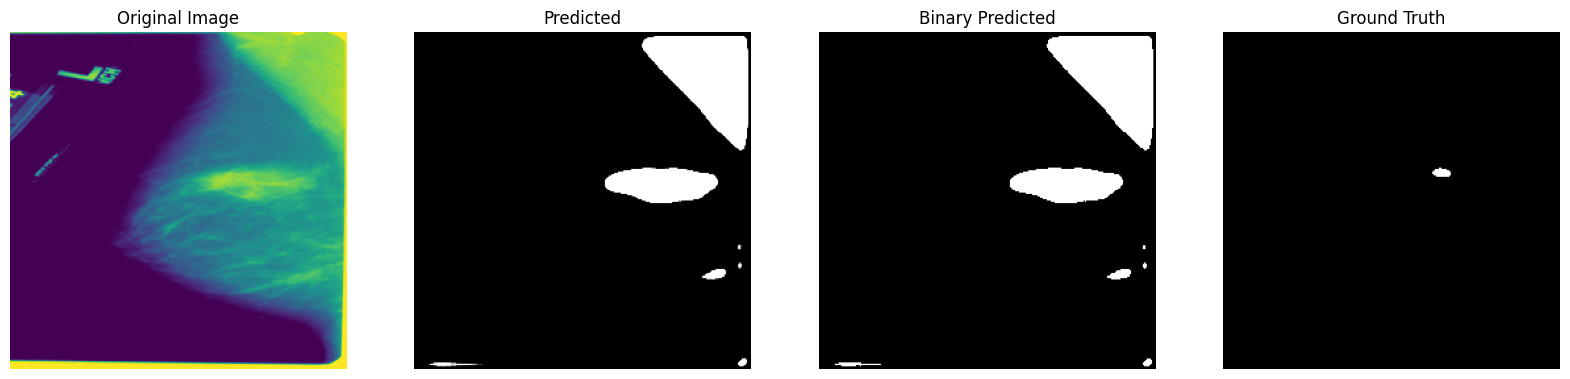

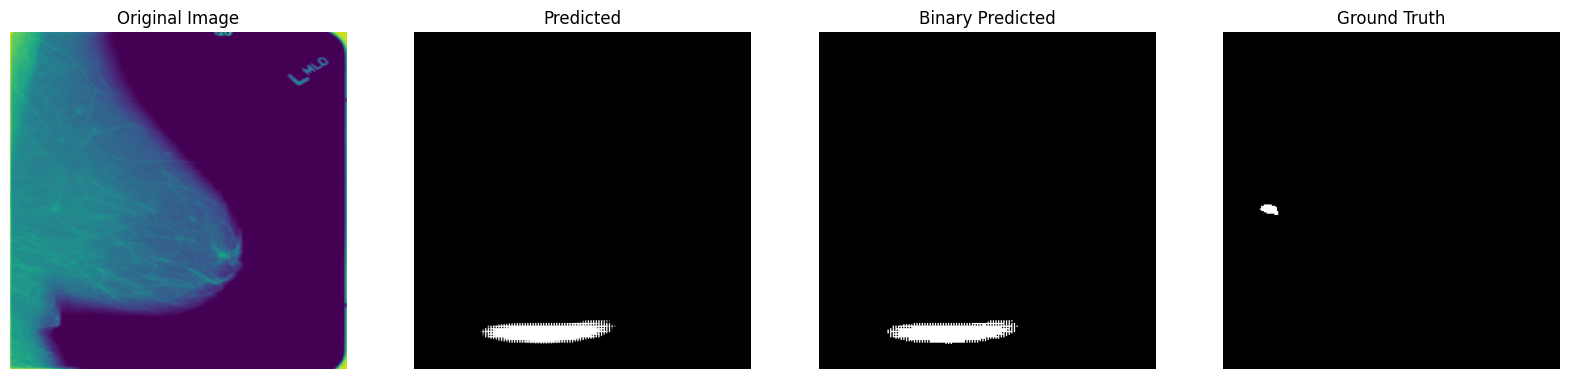

(<keras.engine.functional.Functional at 0x7fd9262835b0>,
 <keras.callbacks.History at 0x7fd926232590>)

In [ ]:
train("iou_opt1",opt = optimizer(0.001), loss = iou_loss1)

optimizer 2


 Model is training

Epoch 1: val_loss improved from inf to 0.99397, saving model to /content/drive/MyDrive/models/iou_opt2.h5

Epoch 2: val_loss did not improve from 0.99397

Epoch 3: val_loss did not improve from 0.99397

Epoch 4: val_loss did not improve from 0.99397

Epoch 5: val_loss did not improve from 0.99397

Epoch 6: val_loss did not improve from 0.99397

Epoch 7: val_loss did not improve from 0.99397

Epoch 8: val_loss did not improve from 0.99397

Epoch 9: val_loss did not improve from 0.99397

Epoch 10: val_loss did not improve from 0.99397

Epoch 11: val_loss did not improve from 0.99397
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping

 Model history


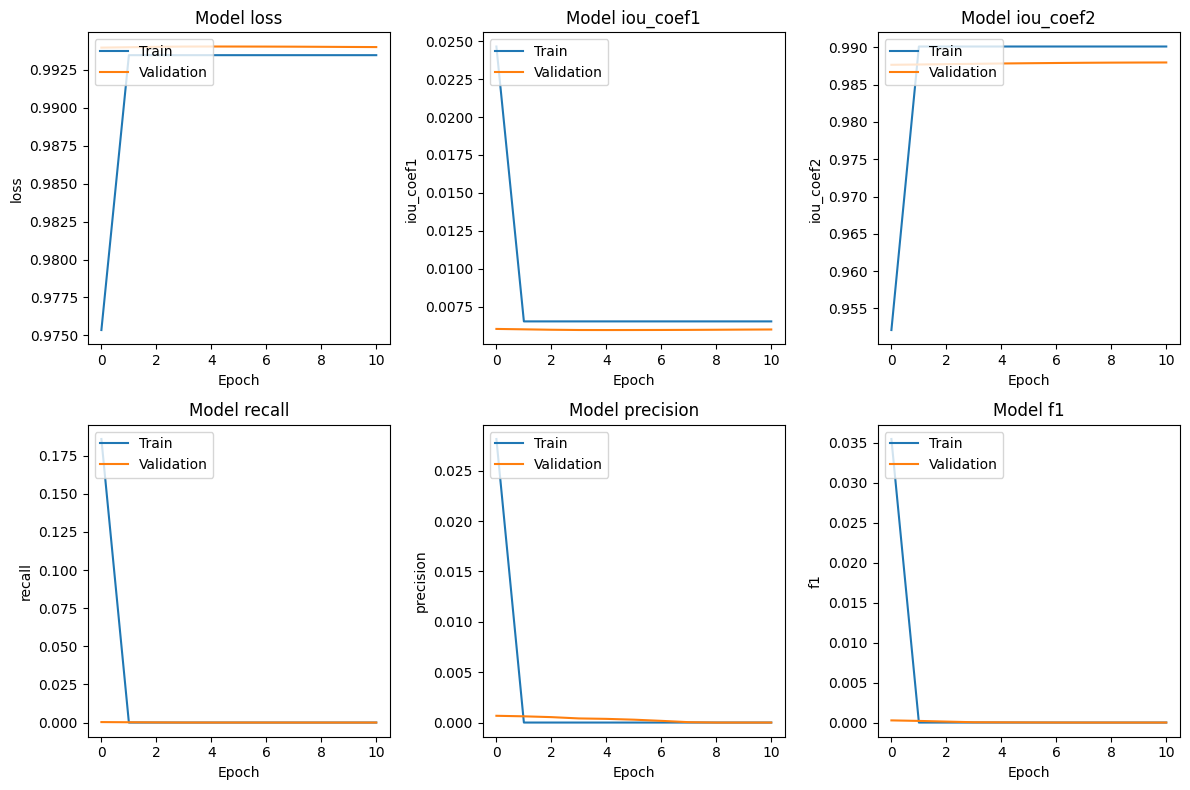



 predicting on a test set
23/23 [==============================] - 4s 165ms/step

 plotting a sample of the predicted output


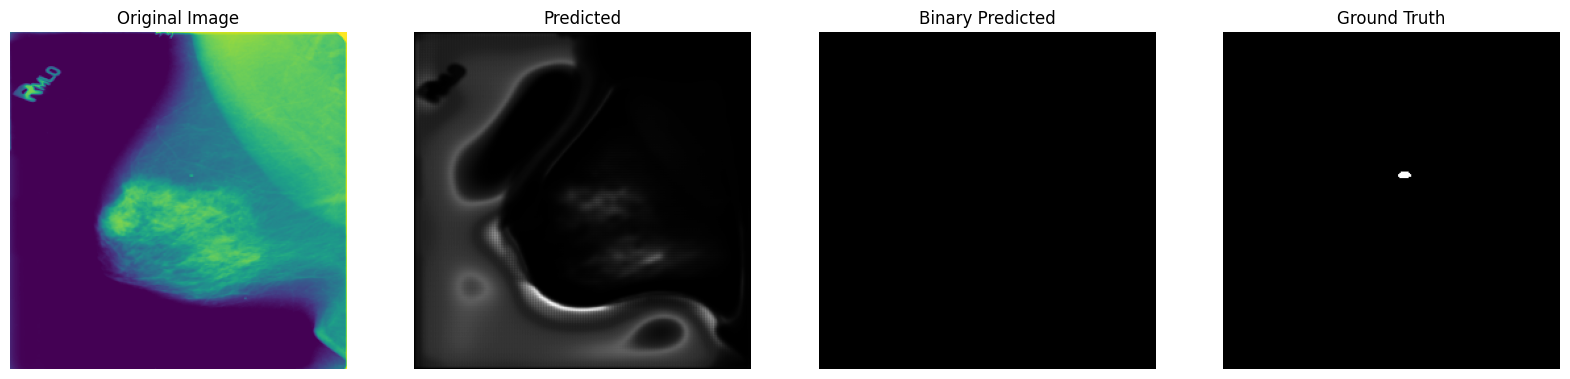

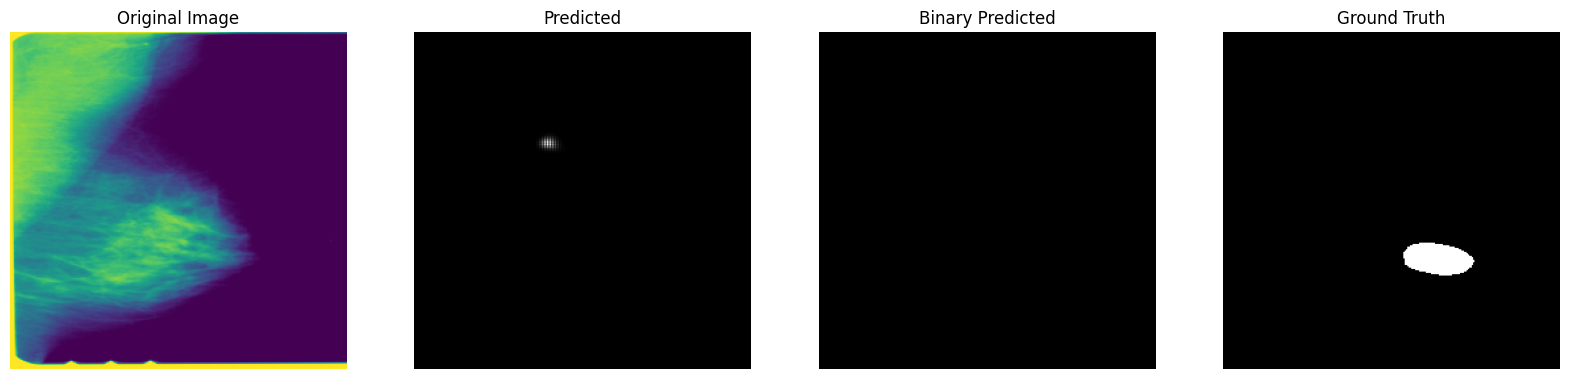

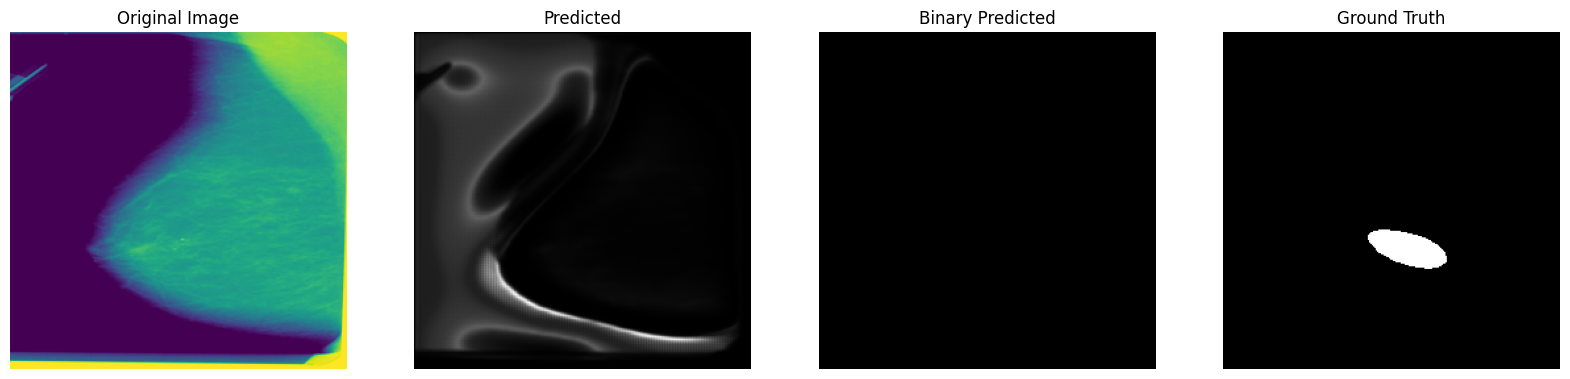

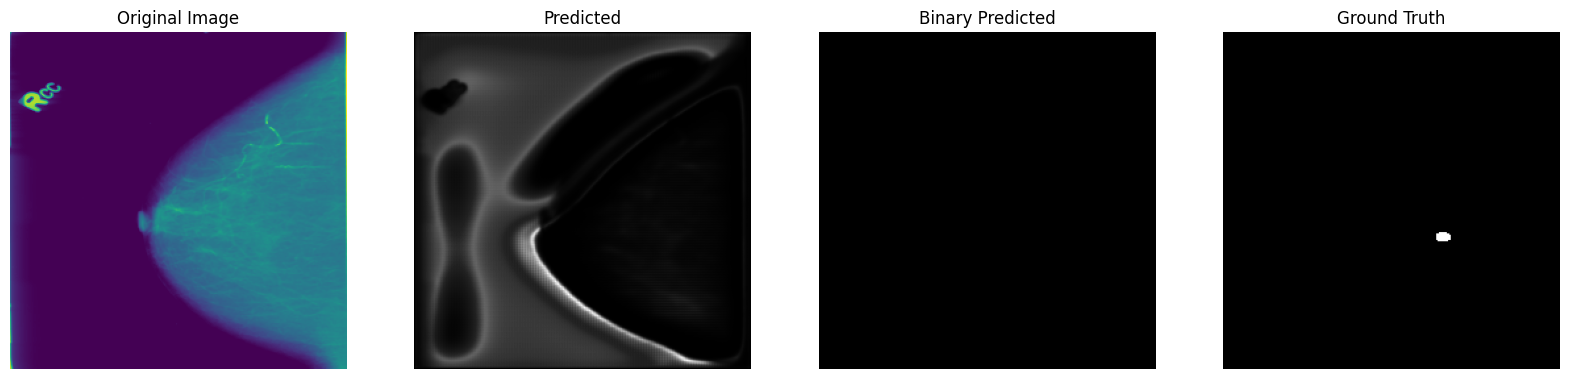

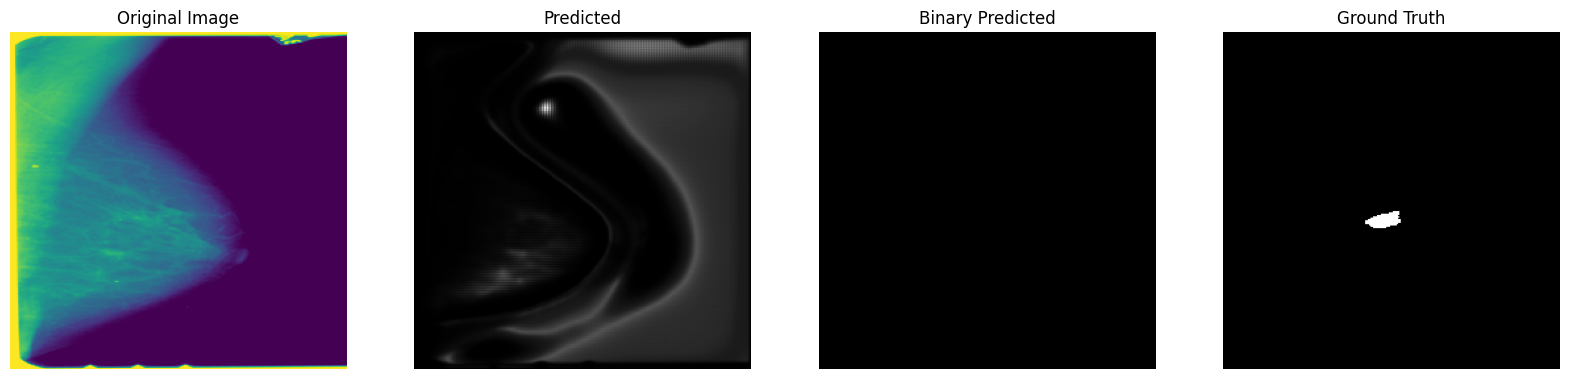

(<keras.engine.functional.Functional at 0x7fd912f38d30>,
 <keras.callbacks.History at 0x7fd912f70940>)

In [ ]:
train("iou_opt2",opt = optimizer(lr_schedule()), loss = iou_loss1)

##using focal loss


 Model is training

Epoch 1: val_loss improved from inf to 0.01316, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 2: val_loss improved from 0.01316 to 0.01197, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 3: val_loss did not improve from 0.01197

Epoch 4: val_loss improved from 0.01197 to 0.01193, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 5: val_loss improved from 0.01193 to 0.01173, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 6: val_loss improved from 0.01173 to 0.01169, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 7: val_loss improved from 0.01169 to 0.01168, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 8: val_loss did not improve from 0.01168

Epoch 9: val_loss improved from 0.01168 to 0.01122, saving model to /content/drive/MyDrive/models/focal_opt1.h5

Epoch 10: val_loss did not improve from 0.01122

Epoch 11: val_loss improved from 0.01122 to 0.0

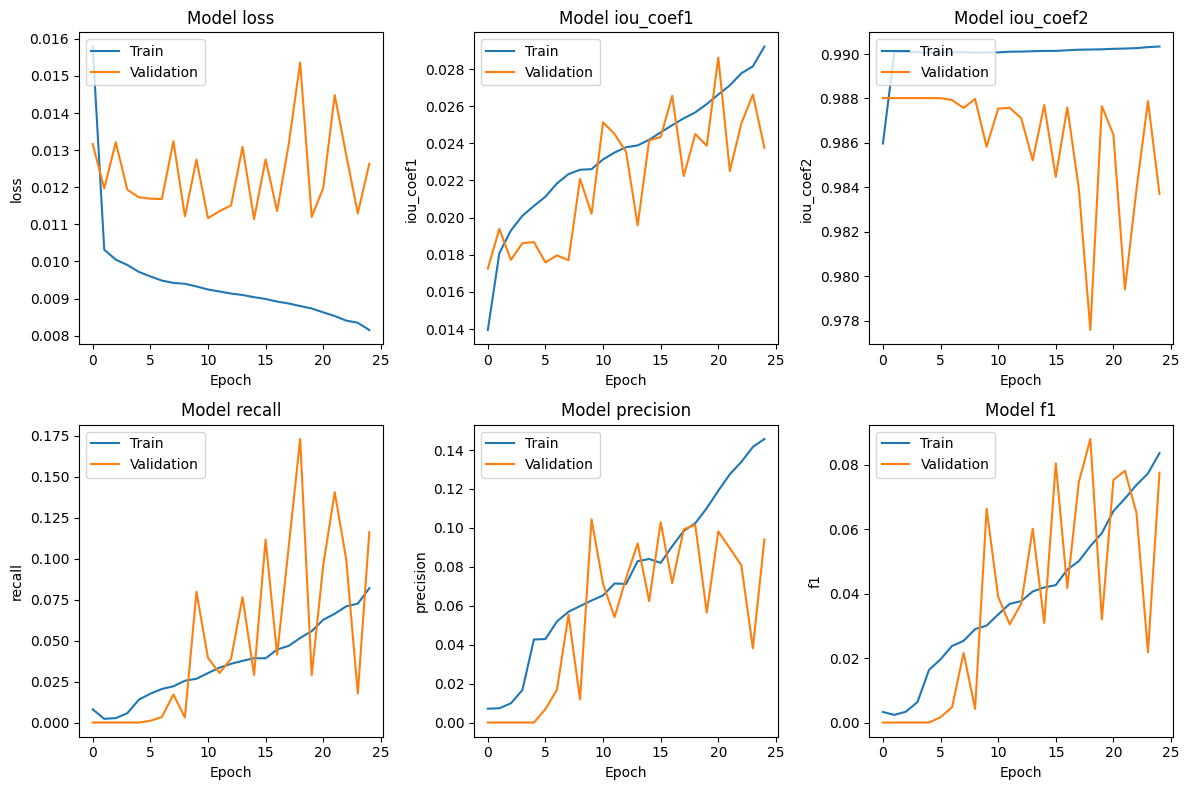



 predicting on a test set
23/23 [==============================] - 4s 167ms/step

 plotting a sample of the predicted output


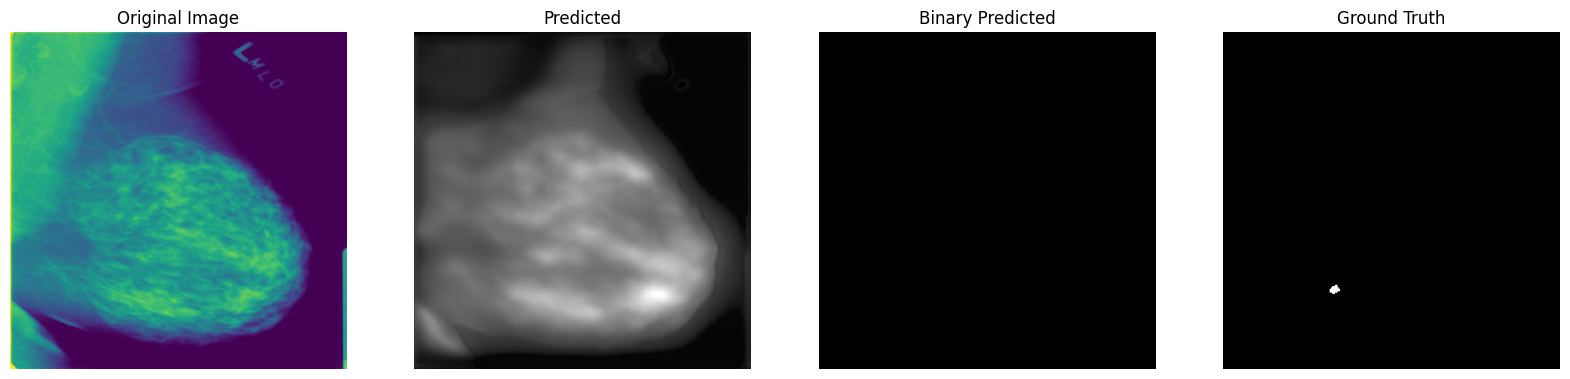

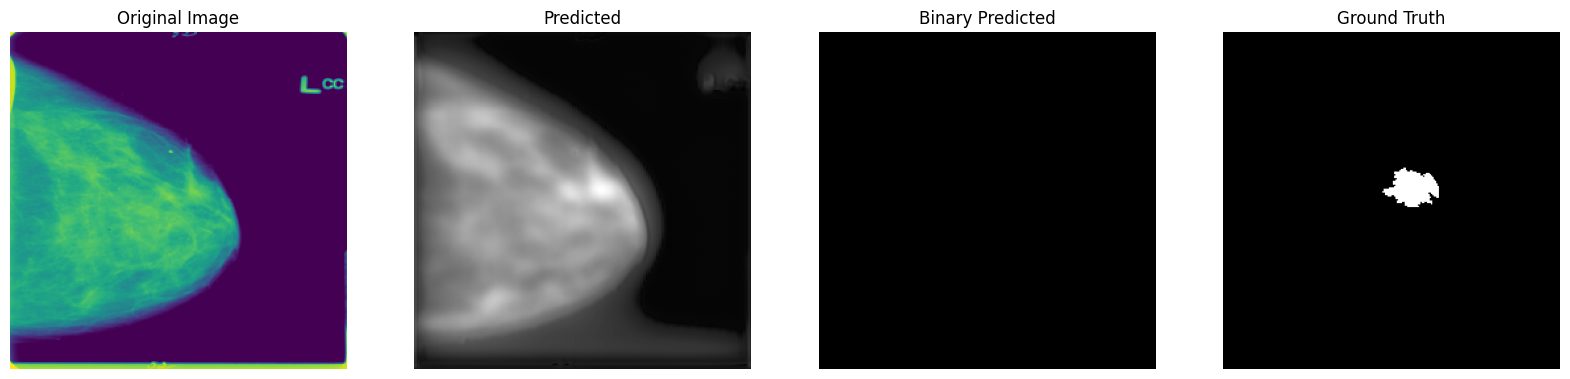

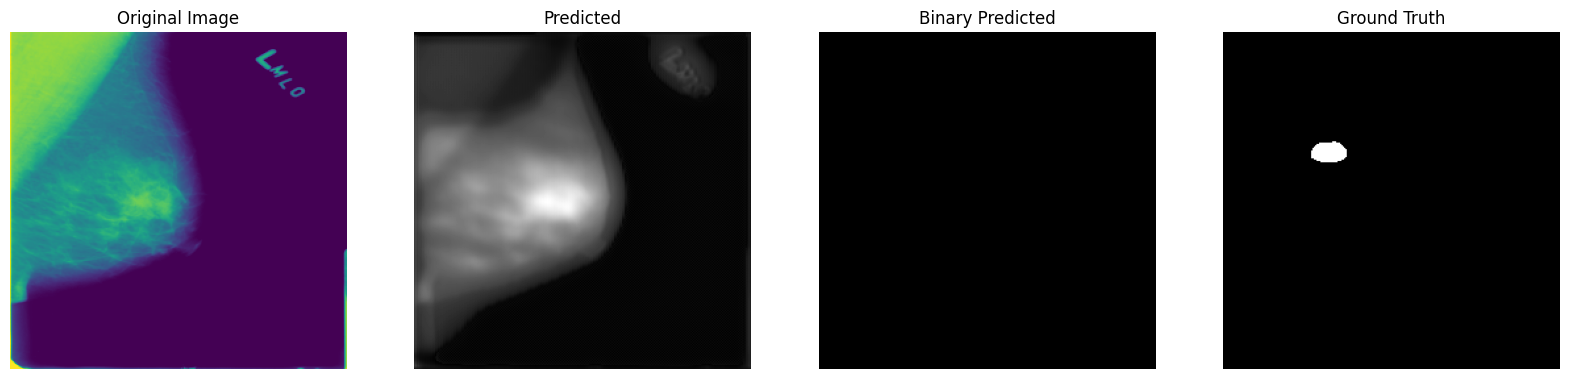

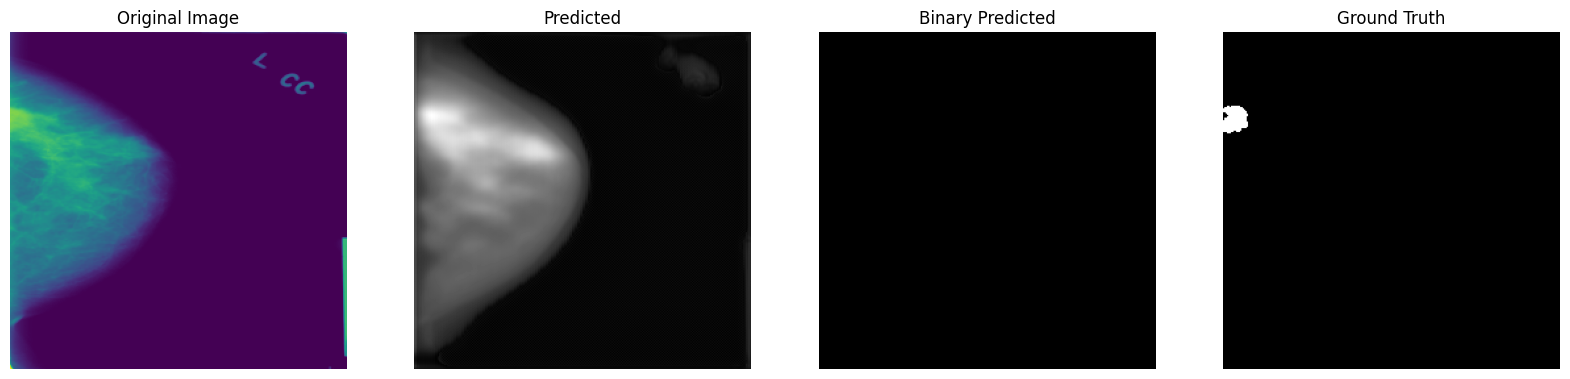

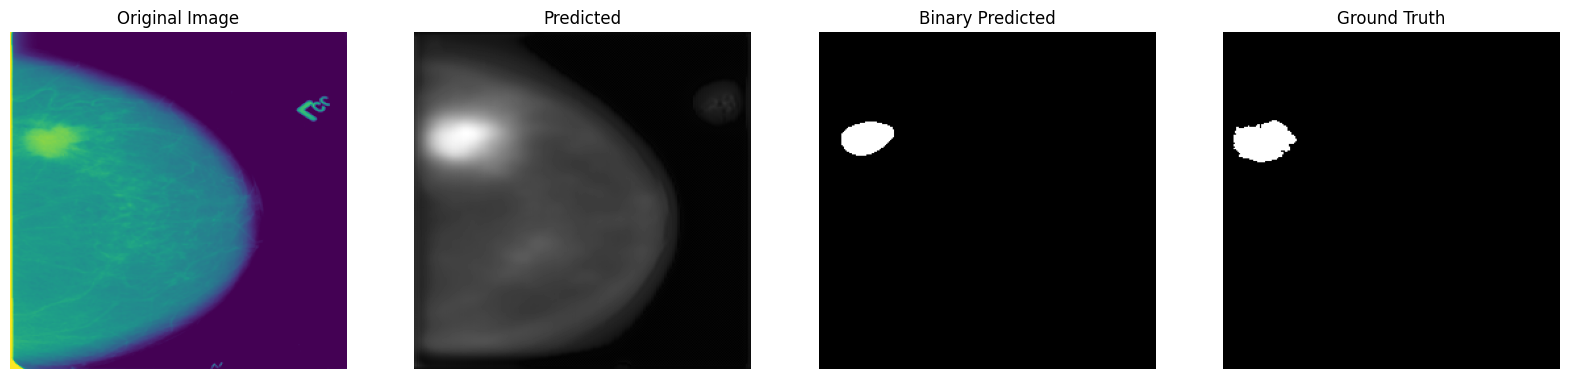

(<keras.engine.functional.Functional at 0x7fd8f3691f90>,
 <keras.callbacks.History at 0x7fd8f16b73d0>)

In [ ]:
#optimizor 1 
train("focal_opt1",opt = optimizer(0.001), loss = focal_loss)


 Model is training

Epoch 1: val_loss improved from inf to 0.01283, saving model to /content/drive/MyDrive/models/focal_opt2.h5

Epoch 2: val_loss did not improve from 0.01283

Epoch 3: val_loss improved from 0.01283 to 0.01243, saving model to /content/drive/MyDrive/models/focal_opt2.h5

Epoch 4: val_loss did not improve from 0.01243

Epoch 5: val_loss did not improve from 0.01243

Epoch 6: val_loss did not improve from 0.01243

Epoch 7: val_loss did not improve from 0.01243

Epoch 8: val_loss did not improve from 0.01243

Epoch 9: val_loss did not improve from 0.01243

Epoch 10: val_loss did not improve from 0.01243

Epoch 11: val_loss did not improve from 0.01243

Epoch 12: val_loss did not improve from 0.01243

Epoch 13: val_loss did not improve from 0.01243
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping

 Model history


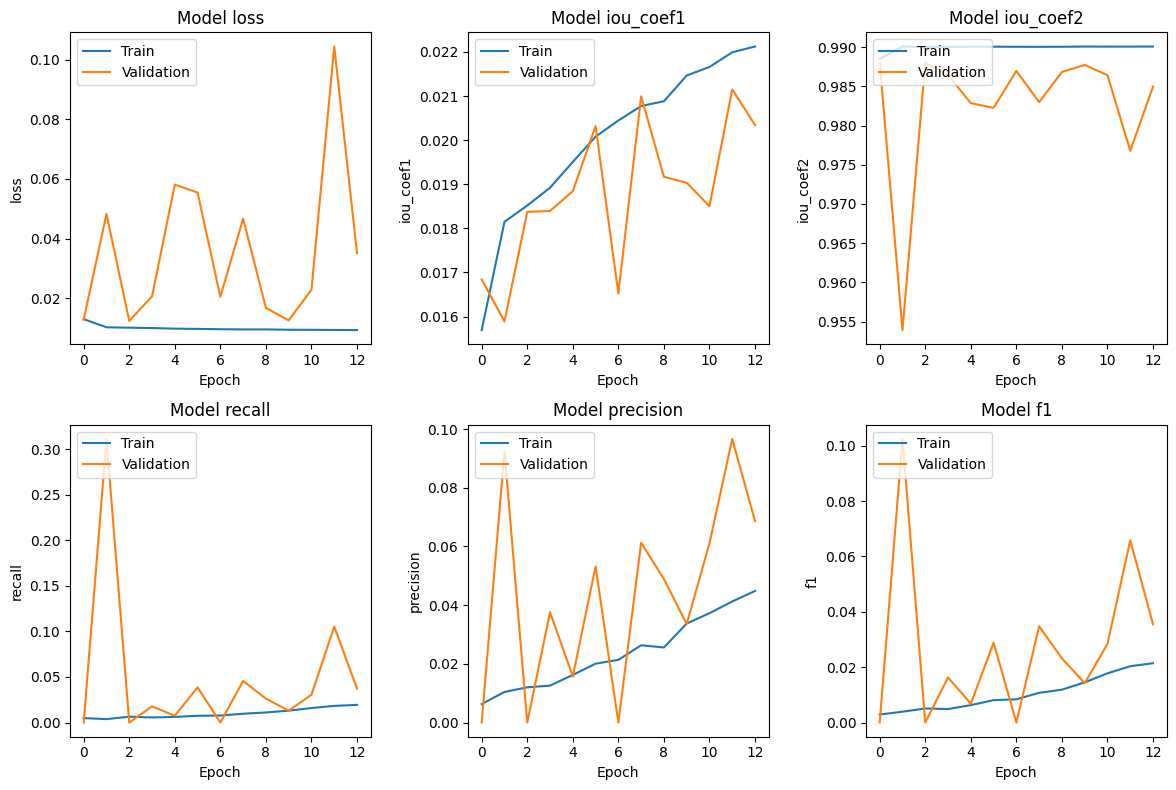



 predicting on a test set
23/23 [==============================] - 4s 166ms/step

 plotting a sample of the predicted output


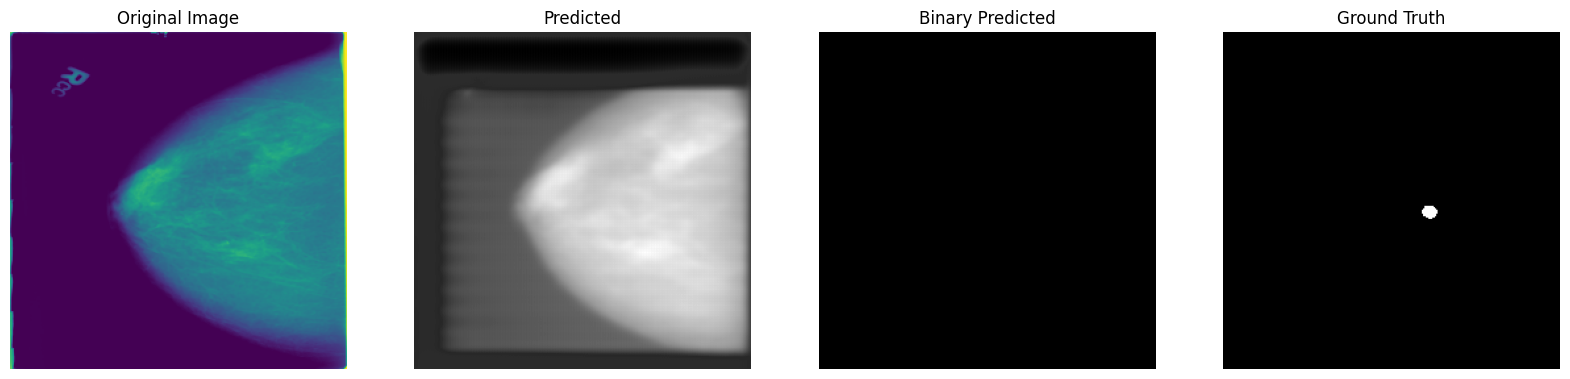

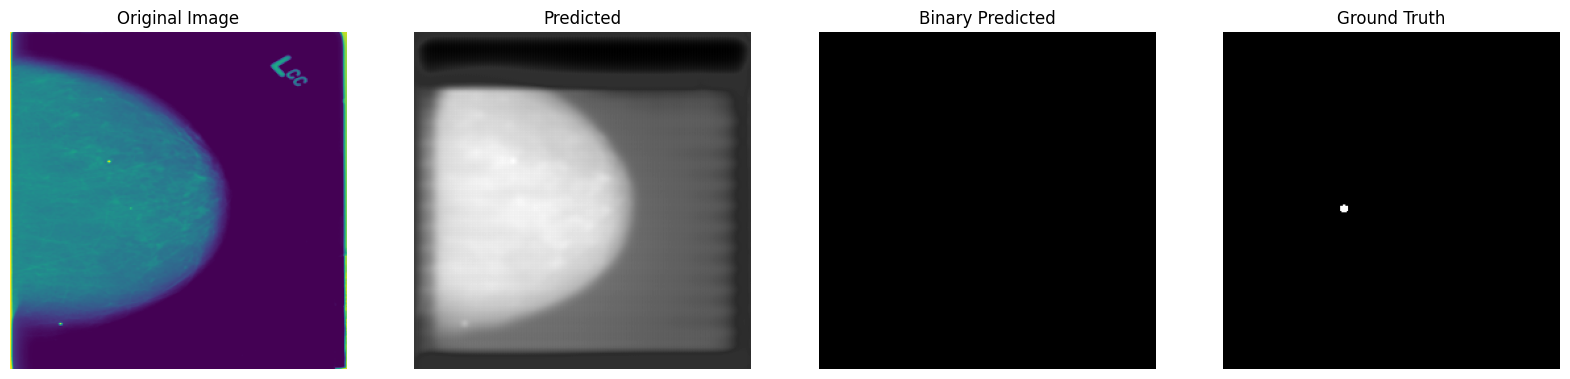

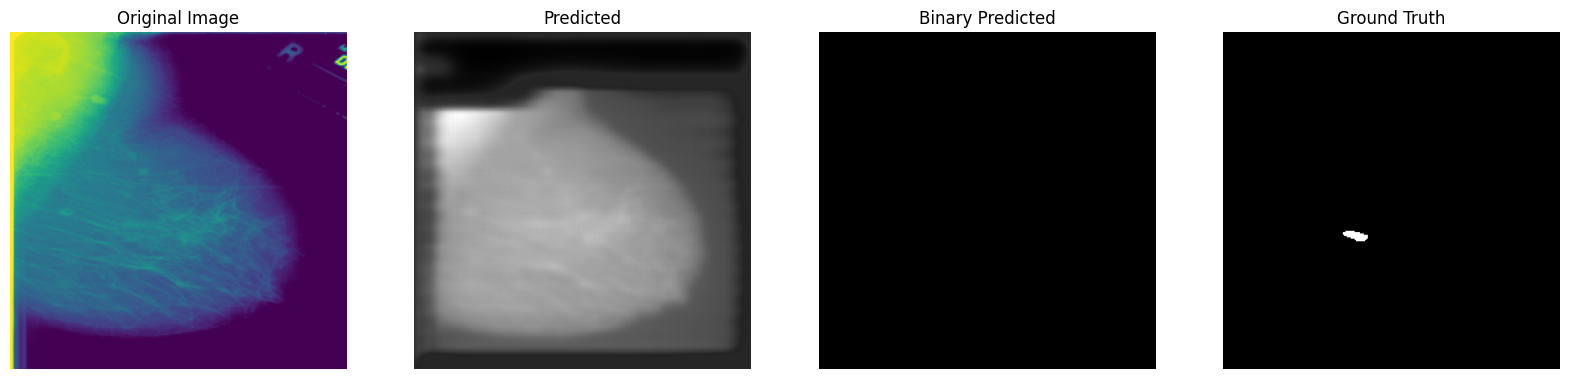

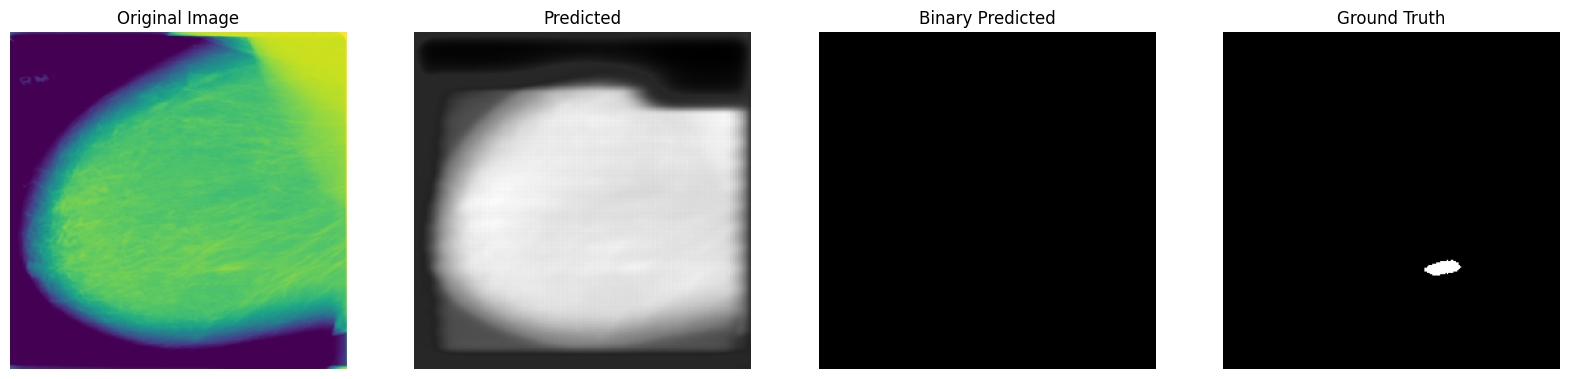

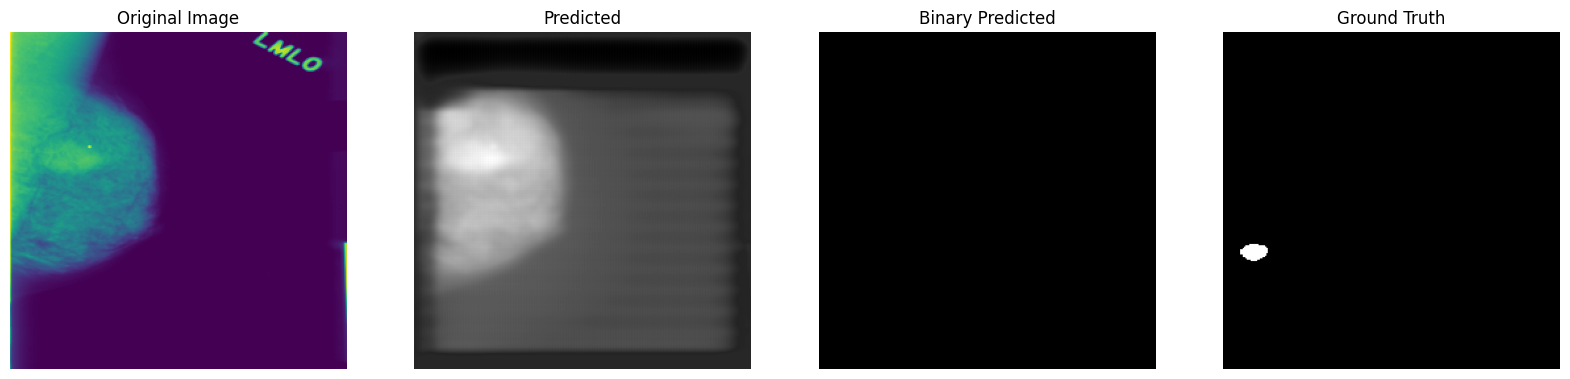

(<keras.engine.functional.Functional at 0x7fd9218e72b0>,
 <keras.callbacks.History at 0x7fd921703df0>)

In [ ]:
#optimizer 2
train("focal_opt2",opt = optimizer(lr_schedule()), loss = focal_loss)

##dice loss combined with binary crossentropy

In [ ]:
train("bi_dice_opt1",opt = optimizer(0.001), loss = loss1)


 Model is training


TypeError: ignored

In [ ]:
train("bi_dice_opt2",opt = optimizer(lr_schedule()), loss = loss1)

##dice loss combined with iou coeff 

In [ ]:
train("iou_dice_opt1",opt = optimizer(0.001), loss = loss2)

In [ ]:
train("iou_dice_opt2",opt = optimizer(lr_schedule()), loss = loss2)

##best 

##Prediction

**prediction**